# Solutions to Problem 10.1: Lossy Compression With a (VAE) — With Entropy Coder

**Course:** Data Compression With And Without Deep probabilistic models (Prof. Robert Bamler at University of Tuebingen)

- This notebook is part of Problem Set 10, published on 14 July 2022 and discussed on 22 July 2022.
- You can download the full problem set (and solutions) from the [course website](https://robamler.github.io/teaching/compress22/).

This problem builds on the variational autoencoder (VAE) with box-shaped variational distribution that we implemented on [last week's problem set](https://robamler.github.io/teaching/compress22/problem-set-09.zip).

- *The first part of this notebook* is just a copy of the solutions to Problem 9.1 on last week's problem set, in which you implemented a VAE that can be used for lossy compression.
  Read the code, make sure you understand what it is doing, and execute the code to train the model.
- *In the second part of this notebook*, you will take the trained model and turn it into an actual lossy compression method by implementing routines for encoding and decoding the latent representation $z$ into and from a compressed bit string.

## Part 1: Variational Autoencoder From Last Week's Problem Set

Below is a copy of the suggested solutions to Problem 9.1 from [last week's problem set](https://robamler.github.io/teaching/compress22/problem-set-09.zip), in which you implemented a VAE that can be used for lossy compression using the method proposed in [Ballé et al., "End-to-end optimized image compression" (ICLR 2017)](https://openreview.net/forum?id=rJxdQ3jeg).
Read the code, make sure you understand what it is doing, and execute it to train the model.


In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import time

/home/robamler/Dropbox/teaching/compress22/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
USE_CUDA = False # change to True if you have a compatible GPU
RANDOM_SEED = 20220625
BATCH_SIZE = 100
EPOCHS = 50
BATCHES_BETWEEN_LOGGING = 100
LATENT_DIM = 8

In [3]:
device = torch.device("cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

### Visualize some of the training data

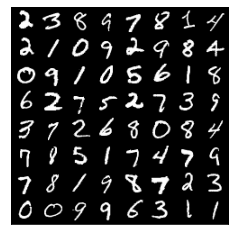

In [5]:
for batch, _ in train_loader:
    ax = plt.imshow(make_grid(batch[:64]).permute((1, 2, 0)))
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    break

### Encoder and Decoder Model

- `Encoder` is a neural network with weights $\phi$.
  It takes a batch of images $x$ as input and outputs a vector $\mu_\phi(x)$ that lives in the latent representation space.
  This vector parameterizes the variational distribution $Q_\phi(Z\,|\,X\!=\!x)$, which is a *uniform* (continuous) distribution over a hypercube of width 1 that is centered around $\mu_\phi(x)$.
  This means that the probability density $Q_\phi(Z\!=\!z\,|\,X\!=\!x)$ is constant (one) for all points $z$ that satisfy $|z_i-\mu_\phi(x)\leq \frac12|$ for all coordinates $i$, and the density is zero everywhere else.
- `Decoder` is a neural network with weights $\theta$ that takes a latent representation $z$ as input and outputs the parameters $\hat x_\theta(z)$ of the likelihood $P_\theta(X\,|\,Z\!=\!z)$.
  Here, we model the likelihood $P_\theta(X\,|\,Z\!=\!z)$ as a Bernoulli distribution, which is a fancy way of saying that each pixel $X_i$ can be either black or white, and it is white with probability $\hat x_\theta(z) \in(0,1)$.

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5)
        self.fc = nn.Linear(in_features=8*8*8, out_features=LATENT_DIM)

    def forward(self, x):
        h = torch.relu(self.conv1(x))
        h = torch.relu(self.conv2(h)).view(-1, 8 * 8 * 8)
        q_mean = self.fc(h)  # (no activation function on last layer)
        return q_mean

In [7]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=LATENT_DIM, out_features=8*8*8)
        self.deconv1 = nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=5)
        self.deconv2 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=5, stride=2, output_padding=1)

    def forward(self, z):
        h = torch.relu(self.fc(z)).view(-1, 8, 8, 8)
        h = torch.relu(self.deconv1(h))
        return torch.sigmoid(self.deconv2(h))

### Reparameterization Gradients

We use reparameterization gradients to maximize the ELBO (see Problem 8.2 (b) on Problem Set 8).
However, there are two differences compared to Problem 8.2. (b):

- The variational distribution is not a Gaussian distribution but instead a uniform distribution width width 1 in each dimension.
  This is why we add uniformly distributed noise from the interval $[-\frac12, \frac12]$ (using `torch.rand(mean.shape) - 0.5`).
- The uniform noise is only introduced at training time (when `training == True` below).
  When we use the model for compression, we instead round each coordinate to the nearest integer (it would be better if we do the same at training time, but the nondifferentiable rounding operation would make gradient based optimization difficult; the uniform variational distribution with width 1 was chosen to resemble rounding on average).

In [8]:
def reparameterize(mean, training):
    if training:
        eps = torch.rand(mean.shape) - 0.5
        return mean + eps
    else:
        return torch.round(mean)

### Learnable Prior

As discussed on [Problem Set 9](https://robamler.github.io/teaching/compress22/problem-set-09.zip), we have to make the width of the prior adjustable since the variational distribution has a fixed width.
We use a Gaussian prior with zero mean and learnable diagonal variance,
$$
  P_\theta(Z) = \mathcal N(0,\text{diag}(\gamma_1^2, \gamma_2^2,\ldots)).
$$
To ensure that the variance is positive, we parametrize it as $\gamma^2 = \exp(\texttt{prior\_log\_variance})$.
The initialization of `prior_log_variance` with $1$ is somewhat arbitrary but seems to work reasonably well here.

In [9]:
prior_log_variance = torch.nn.Parameter(torch.ones((LATENT_DIM,))) 

### Analytic Calculation of KL-Divergence

We minimize a loss function that trades off bit rate vs. distortion.
The trade-off is controlled by a scalar hyperparameter $\beta>0$.
For $\beta=1$, the loss function is the negative ELBO.

$$
\mathcal L_\beta(\theta,\phi) = -\mathbb E_{Q_\phi(Z|X\!=\!x)}\big[ \log P_\theta(X\! =\!x\,|\,Z)\big] + \beta D_\text{KL}\big(Q_\phi(Z\,|\,X\! =\!x) \,\big|\;\!\!\big|\,  P(Z)\big).
$$

When we minimize $\mathcal L_\beta(\theta,\phi)$ over $\theta$ and $\phi$, we *estimate* the first term on the right-hand side by drawing a random sample from $z\sim Q_\phi(Z\,|\,X\! =\!x)$ and then evaluating $\log P(X\! =\!x\,|\,Z\!=\!z)$ for this sample.
By contrast, we evaluate the second term on the right-hand side analytically,

\begin{alignat}{1}
  D_\text{KL}\big(Q_\phi(Z\,|\,X\! =\!x) \,\big|\;\!\!\big|\,  P_\theta(Z)\big)
  &= \sum_i D_\text{KL}\big(Q_\phi(Z_i\,|\,X\! =\!x) \,\big|\;\!\!\big|\,  P_\theta(Z_i)\big) \\
  &= \sum_i \int_{{\mu_\phi(x)}_i-\frac12}^{{\mu_\phi(x)}_i+\frac12} \big[ \log Q_\phi(Z_i\!=\!z_i\,|\,X\!=\!x) - \log P_\theta(Z_i\!=\!z_i) \big] \\
  &= \sum_i \int_{{\mu_\phi(x)}_i-\frac12}^{{\mu_\phi(x)}_i+\frac12} \left[ \log (1) - \log \left( \frac{1}{\sqrt{2\pi\gamma_i^2}} e^{-z_i^2/(2\gamma_i^2)} \right) \right] \\
  &= \frac12 \sum_i \int_{{\mu_\phi(x)}_i-\frac12}^{{\mu_\phi(x)}_i+\frac12} \left[ \log(2\pi\gamma_i^2) + \frac{1}{\gamma_i^2} z_i^2\right] \\
  &= \frac12 \sum_i \left[ \log(2\pi\gamma_i^2) + \frac{1}{3\gamma_i^2}  \left(\left({\mu_\phi(x)}_i+\frac12\right)^3 - \left({\mu_\phi(x)}_i-\frac12\right)^3 \right) \right] \\
  &= \frac12 \sum_i \left[ \log(2\pi\gamma_i^2) + \frac{1}{\gamma_i^2}  \left({\mu_\phi(x)}_i^2 + \frac{1}{12} \right) \right].
\end{alignat}

In [10]:
def kl_divergence_from_prior(q_mean):
    prior_precision = (-prior_log_variance).exp()
    return 0.5 * torch.sum(
        np.log(2*np.pi) + prior_log_variance +
        prior_precision * (q_mean.pow(2) + 1/12)
    )

### Training and Test procedure

The following cells define the training and testing procedure.
Notice that the loss function is given by

$$
    \texttt{loss} = \texttt{distortion} + \beta \times \texttt{bitrate}
$$

where $\beta>0$ is a (fixed) scalar parameter that controls the trade-off between reconstruction errors ("distortion") and bit rate.
For $\beta=1$, we have $\texttt{loss}=-\text{ELBO}$.
For $\beta>1$, the model is trained to favor short bit rates even if achieving this requires higher distortion.
For $\beta<1$, the model is trained to favor low distortion (i.e., high reconstruction quality) even if achieving this requires higher bit rates.

In [11]:
def encoder_decoder_roundtrip(encoder, decoder, x, training):
    q_mean = encoder(x)
    bitrate = kl_divergence_from_prior(q_mean)
    z = reparameterize(q_mean, training)
    x_hat = decoder(z)
    log_likelihood = -F.binary_cross_entropy(x_hat, x, reduction='sum')
    distortion = -log_likelihood
    return bitrate, distortion, x_hat

In [12]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
if torch.cuda.device_count() > 1:
    encoder = nn.DataParallel(encoder)
    decoder = nn.DataParallel(decoder)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

In [13]:
def train(epoch, beta):
    # Set encoder and decoder models into training mode.
    encoder.train()
    decoder.train()

    total_loss = 0
    for batch_idx, (batch, _) in enumerate(train_loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        bitrate, distortion, _ = encoder_decoder_roundtrip(encoder, decoder, batch, True)
        loss = distortion + beta * bitrate
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % BATCHES_BETWEEN_LOGGING == 0:
            print(
                f'Training epoch {epoch} [{batch_idx * len(batch)}/{len(train_loader.dataset)}' +
                f' ({100. * batch_idx / len(train_loader):.0f}%)]:' +
                f' loss = {loss.item() / len(batch):.6f};'
                f' bits per pixel = {bitrate.item() / (len(batch) * np.log(2) * 28**2):.6f};'
                f' distortion = {distortion.item() / len(batch):.6f}'
            )

    return total_loss / len(train_loader.dataset)

In [14]:
def test(render_reconstructions=False):
    # Set encoder and decoder models into evaluation mode.
    encoder.eval()
    decoder.eval()

    rendered_x_hat = None
    total_bitrate = 0
    total_distortion = 0
    with torch.no_grad():
        for i, (batch, _) in enumerate(test_loader):
            batch = batch.to(device)
            bitrate, distortion, reconstruction = encoder_decoder_roundtrip(encoder, decoder, batch, False)
            total_bitrate += bitrate.item()
            total_distortion += distortion.item()
            if i == 0 and render_reconstructions:
                n = min(batch.size(0), 8)
                comparison = torch.cat([batch[:n],
                                        reconstruction.view(BATCH_SIZE, 1, 28, 28)[:n]])
                rendered_x_hat = make_grid(comparison.cpu()).permute((1, 2, 0))

    return total_bitrate / len(test_loader.dataset), total_distortion / len(test_loader.dataset), rendered_x_hat

In [15]:
def create_figure():
    figure, (samples_plot, reconstructions_plot) = plt.subplots(1, 2)
    samples_plot.set_title('samples')
    samples_plot.xaxis.set_visible(False)
    samples_plot.yaxis.set_visible(False)
    reconstructions_plot.set_title('test images and\ntheir reconstructions')
    reconstructions_plot.xaxis.set_visible(False)
    reconstructions_plot.yaxis.set_visible(False)
    return figure, samples_plot, reconstructions_plot

Training epoch 1 [0/60000 (0%)]: loss = 569.914805; bits per pixel = 0.021130; distortion = 558.431953
Training epoch 1 [10000/60000 (17%)]: loss = 288.384004; bits per pixel = 0.043124; distortion = 264.949023
Training epoch 1 [20000/60000 (33%)]: loss = 247.341348; bits per pixel = 0.034428; distortion = 228.632285
Training epoch 1 [30000/60000 (50%)]: loss = 224.949355; bits per pixel = 0.034020; distortion = 206.461992
Training epoch 1 [40000/60000 (67%)]: loss = 205.432207; bits per pixel = 0.032754; distortion = 187.632852
Training epoch 1 [50000/60000 (83%)]: loss = 180.457695; bits per pixel = 0.032029; distortion = 163.052490
Epoch 1 of 10 (42 sec): test bits per pixel = 0.0324; test distortion = 161.3959
Prior log variances: [1.2221367, 1.2344282, 1.3140516, 1.2578692, 1.1864457, 1.2168387, 1.0070916, 1.2996479]


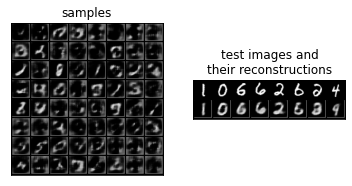

Training epoch 2 [0/60000 (0%)]: loss = 182.379941; bits per pixel = 0.032453; distortion = 164.744199
Training epoch 2 [10000/60000 (17%)]: loss = 174.357930; bits per pixel = 0.032228; distortion = 156.844414
Training epoch 2 [20000/60000 (33%)]: loss = 166.293633; bits per pixel = 0.031992; distortion = 148.908164
Training epoch 2 [30000/60000 (50%)]: loss = 170.359609; bits per pixel = 0.031414; distortion = 153.288125
Training epoch 2 [40000/60000 (67%)]: loss = 164.114023; bits per pixel = 0.032714; distortion = 146.336396
Training epoch 2 [50000/60000 (83%)]: loss = 168.429629; bits per pixel = 0.032082; distortion = 150.995547
Epoch 2 of 10 (46 sec): test bits per pixel = 0.0322; test distortion = 141.7675
Prior log variances: [1.3052444, 1.3385856, 1.4397405, 1.3897202, 1.5508397, 1.2912735, 1.2864964, 1.3887179]
Training epoch 3 [0/60000 (0%)]: loss = 159.723574; bits per pixel = 0.032442; distortion = 142.093965
Training epoch 3 [10000/60000 (17%)]: loss = 159.937881; bits p

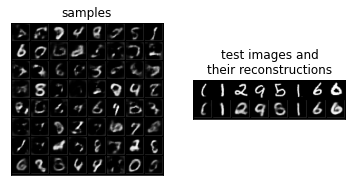

Training epoch 6 [0/60000 (0%)]: loss = 136.357207; bits per pixel = 0.032300; distortion = 118.804365
Training epoch 6 [10000/60000 (17%)]: loss = 137.171553; bits per pixel = 0.032412; distortion = 119.558105
Training epoch 6 [20000/60000 (33%)]: loss = 138.650273; bits per pixel = 0.032919; distortion = 120.761348
Training epoch 6 [30000/60000 (50%)]: loss = 132.996758; bits per pixel = 0.032482; distortion = 115.345166
Training epoch 6 [40000/60000 (67%)]: loss = 134.081338; bits per pixel = 0.033179; distortion = 116.050723
Training epoch 6 [50000/60000 (83%)]: loss = 127.215859; bits per pixel = 0.032706; distortion = 109.442617
Epoch 6 of 10 (46 sec): test bits per pixel = 0.0329; test distortion = 113.6810
Prior log variances: [1.3446616, 1.703564, 1.4328332, 1.7664645, 1.9719734, 1.5870203, 1.5369414, 1.3283496]
Training epoch 7 [0/60000 (0%)]: loss = 132.047764; bits per pixel = 0.033235; distortion = 113.987129
Training epoch 7 [10000/60000 (17%)]: loss = 126.018145; bits pe

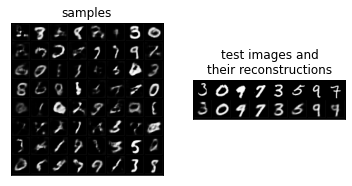

In [16]:
BETA = 1.0 # TODO: change this to different values and observe the rate-distortion trade-off

torch.manual_seed(RANDOM_SEED)

def reset_parameters(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

encoder.apply(reset_parameters)
decoder.apply(reset_parameters)
prior_log_variance = torch.nn.Parameter(torch.ones((LATENT_DIM,))) 

encoder = Encoder().to(device)
decoder = Decoder().to(device)
prior_log_variance = prior_log_variance.to(device)
if torch.cuda.device_count() > 1:
    encoder = nn.DataParallel(encoder)
    decoder = nn.DataParallel(decoder)

# Note that `prior_log_variance` is now also part of the parameters over
# which we optimize:
learnable_parameters = list(encoder.parameters()) + list(decoder.parameters()) + [prior_log_variance]
optimizer = optim.Adam(learnable_parameters, lr=1e-3)

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()
    show_plots = epoch == 1 or epoch % 5 == 0  

    train(epoch, BETA)
    test_bitrate, test_distortion, x_hat = test(render_reconstructions=show_plots)
    end_time = time.time()
    print(
        f'Epoch {epoch} of {EPOCHS} ({end_time - start_time:.0f} sec): ' +
        f'test bits per pixel = {test_bitrate/ (np.log(2) * 28**2):.4f}; ' +
        f'test distortion = {test_distortion:.4f}'
    )
    print(f'Prior log variances: {[i for i in prior_log_variance.cpu().detach().numpy()]}')

    if show_plots:
        figure, samples_plot, reconstructions_plot = create_figure()
        with torch.no_grad():
            sample = (torch.exp(0.5 * prior_log_variance) * torch.randn(64, LATENT_DIM)).to(device)
            sample = decoder(sample).cpu()
            samples_plot.imshow(make_grid(sample.view(64, 1, 28, 28)).permute((1, 2, 0)))
        reconstructions_plot.imshow(x_hat)
        plt.show()

## Part 2: Entropy Coding

Now that you have a variational autoencoder that is designed for lossy data-compression, let's actually use it to compress some test images.

Run the code from Part 1 above to train a VAE.
You may want to interrupt the training process with Ctrl+C after about 5 epochs.
This should be enough to get a VAE that's good enough so that you can see whether what you implement below is correct.
Once you're done filling in the blanks in this notebook, restart your notebook kernel, train the model for the entire 50 epochs, and also try out various values for the rate/distortion trade-off `BETA`.

To get started, let's install and import two libraries:

- [`scipy`](https://scipy.org/), so that we can easily plot some probability density functions; and
- [`constriction`](https://bamler-lab.github.io/constriction/) for lossless entropy coding.

In [17]:
import sys
!{sys.executable} -m pip install scipy constriction~=0.2.4
import scipy.stats, constriction

### Goal

You will implement the following compression pipeline:

- **Encoder:**
  - use the encoder network $\mu_\phi$ to map an image $x$ to a discrete latent representation $\hat z := \lfloor \mu_\phi(x)\rceil$ where $\lfloor\cdot\rceil$ denotes rounding each coordinate to the nearest integer.
  - encode $\hat z$ into a bit string using a near-optimal stream code and, for each coordinate $\hat z_i$, an entropy model $P_\theta(\hat Z_i)$ (see below).
- **Decoder:**
  - decode $\hat z$ from a bit string using again the entropy models $P_\theta(\hat Z_i)$ (see below).
  - use the decoder network to map $\hat z$ to a reconstruction $\hat x_\theta(\hat z)$.

### Entropy Model for Lossless Compression

The entropy models $P(\hat Z_i)$ that we use to encode and decode each coordinate of $\hat z$ have to be known to both the encoder and the decoder before they begin to communicate any compressed messages.
Therefore, $P(\hat Z_i)$ must not depend on the data point $x$.
We define $P_\theta(\hat Z_i)$ as a *quantized* form of the prior distribution $P_\theta(Z)$.

We discuss the quantization of the prior in more detail below.
Before we do so, let's check if the prior is even a good entropy model.
When we trained the VAE, the KL-term in the loss function tried to fit the prior $P_\theta(Z_i)$ to the marginal variational distribution $Q_\phi(Z) = \mathbb E_{x\sim\text{training data}}[Q_\phi(Z\,|\,X\!=\!x)]$.
Ideally, minimizing this KL-term should have had the effect that, when we map some random input images~$x$ to latent space using the trained encoder model, the distribution of latent representations that we obtain should resemble the trained prior.
However, since our prior is quite constrained, this may not always work perfectly.
The following plots compare the prior density functions for each of the 8 latent dimensions to the distribution of $z_i$'s in the first batch of our test set (a full analysis should really plot a histogram over the entire test batch, but the following is good enough to get a rough idea).


In [18]:
# First, let's load a batch of test images to get an idea of how the tensor shapes work out:
for sample_x, _ in test_loader:
    break

# map the test images to latent representation space:
sample_z = encoder(sample_x).detach().numpy()
print(f'tensor shapes: x: {sample_x.shape};  z: {sample_z.shape}')

tensor shapes: x: torch.Size([100, 1, 28, 28]);  z: (100, 8)


prior_stds: [2.00104872 2.46315607 1.90698017 2.5731391  2.78608222 2.24732657
 2.19611942 1.89276066]


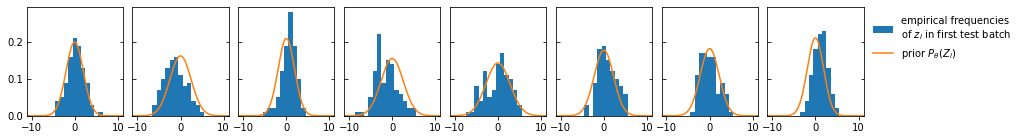

In [19]:
# Now, let's plot the prior and the empirical distributions of the z_i's

prior_precision = np.exp(-prior_log_variance.detach().numpy())
prior_stds = np.exp(0.5 * prior_log_variance.detach().numpy().astype(np.float64))
print(f'prior_stds: {prior_stds}')
prior_means = np.zeros_like(prior_stds)

fig, axs = plt.subplots(1, LATENT_DIM, figsize=(15, 2), sharey=True)
plot_range = 4 * prior_stds.max()

for i, ax in enumerate(axs):
    boundaries_z = np.arange(-round(plot_range) - 0.5, round(plot_range) + 1.5)
    ax.hist(sample_z[:, i], bins=boundaries_z, density=True, label='empirical frequencies\nof $z_i$ in first test batch')
    xs = np.arange(-plot_range, plot_range + 0.01, 0.1)
    ax.plot(xs, scipy.stats.norm(0, prior_stds[i]).pdf(xs), label='prior $P_\\theta(Z_i)$')
    ax.set_xlim((-plot_range, plot_range))
    ax.tick_params(axis="y", direction="in", right=True)

fig.subplots_adjust(wspace=0.1, hspace=0)
axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

#### Your Task

Execute the above cells with your trained VAE and discuss the results.
You should observe that the width of the prior $P(Z_i)$ roughly resembles the width of the empirical distribution for each of the eight $Z_i$'s, but that there are still significant differences between the empirical distribution and the prior.
We will stick with the (quantized) prior for now.
If you want to improve the compression method that you'll implement below then you could replace the (quantized) Gaussian entropy model with one that is based on the empirical frequencies on the training set.

### Quantization of the Prior Model

The prior distributions $P_\theta(Z_i)$ are *continuous* probability density functions since $Z_i\in\mathbb R$.
However, our compression method won't compress the exact value of $z_i$.
Instead, it will encode the rounded value $\hat z_i := \lfloor z_i \rceil$.
In order to calculate the probability that rounding some random $z_i~\sim P_\theta(Z_i)$ to the nearest integer results in some value $\hat z_i\in\mathbb Z$, we have to integrate the prior probability density $P_\theta(Z_i\!=\!z_i)$ over all numbers that round to $\hat z_i$, i.e., over the interval $z_i \in [\hat z_i-\frac12, \hat z_i+\frac12)$:

$$
  P_\theta(\hat Z_i\!=\!\hat z_i) := \int_{\hat z_i+\frac12}^{\hat z_i-\frac12} P_\theta(Z_i\!=\!z_i) \, d z_i.
$$

For practical reasons, it is much easier to work with entropy models $P_\theta(\hat Z_i\!=\!\hat z_i)$ that have a finite support.
Therefore, we clip all coordinates $\hat z_i$ to some range $\{-\texttt{clip\_z}, {-\texttt{clip\_z}+1}, \ldots, \texttt{clip\_z}\}$ where `clip_z` is some large enough integer so that values of $\hat z_i$ outside of this range are extremely improbable.
In the unlikely event that some $z_i$ for some test image lies outside of the clip range, we replace it by $\pm\texttt{clip\_z}$, being aware that this introduces additional distortion in rare cases.

The `constriction` library provides such quantized probability models out of the box for our convenience.
We'll use the class `QuantizedGaussian` here (see [documentation](https://bamler-lab.github.io/constriction/apidoc/python/stream/model.html#constriction.stream.model.QuantizedGaussian)).
Had we used a different prior than a Gaussian, then we could use a [`ScipyModel`](https://bamler-lab.github.io/constriction/apidoc/python/stream/model.html#constriction.stream.model.ScipyModel) or a [`CustomModel`](https://bamler-lab.github.io/constriction/apidoc/python/stream/model.html#constriction.stream.model.CustomModel) instead.

The following code obtains a reasonable value for `clip_z` and defines a generic `QuantizedGaussian` distribution with free parameters for the mean and standard deviation.

In [20]:
clip_z = int(np.round(prior_stds.max() * 5.0 + 1.0)) # Clip to +- 5 standard deviations (but at least +- 1)
print(f'clip_z = {clip_z}')
quantized_gaussian = constriction.stream.model.QuantizedGaussian(-clip_z, clip_z)

clip_z = 15


### Trying it out

Before you put everything together, let's try out how just the task of encoding and decoding the latent representation works.
We'll encode an entire batch worth of latent representation's since single images are so tiny in our toy model.

#### Your Task

Read the part below that encodes $Z$ into a bit string.
Then fill in the blanks in the decoder part.
You may want to refer to the [API documentation](https://bamler-lab.github.io/constriction/apidoc/python/stream/queue.html#constriction.stream.queue.RangeDecoder.decode) (*hint:* the method `decode` can be called in three different variants; you want the variant with signature `decode(model_family, params1, params2, …)`).

In [29]:
clipped_rounded_sample_z = np.clip(sample_z.round().astype(np.int32), -clip_z, clip_z)

lossless_encoder = constriction.stream.queue.RangeEncoder()
for i in range(BATCH_SIZE):
    lossless_encoder.encode(clipped_rounded_sample_z[i], quantized_gaussian, prior_means, prior_stds)

compressed = lossless_encoder.get_compressed()
bitrate = len(compressed) * 32
print(
    f'Compressed {BATCH_SIZE} images into {bitrate} bits ' +
    f'({bitrate/BATCH_SIZE:.2f} bits per image, {bitrate/(BATCH_SIZE * 28**2):.5f} bits per pixel)'
)
print(f'compressed bit string:\n{"".join(f"{i:032b} " for i in compressed)}\n')

lossless_decoder = constriction.stream.queue.RangeDecoder(compressed)
reconstructed_z = np.empty((BATCH_SIZE, LATENT_DIM), dtype=np.int32)
for i in range(BATCH_SIZE):
    reconstructed_z[i] = lossless_decoder.decode(quantized_gaussian, prior_means, prior_stds)

assert np.all(reconstructed_z == clipped_rounded_sample_z)
print('Successfully reconstructed clipped rounded latent representation.')

Compressed 100 images into 2624 bits (26.24 bits per image, 0.03347 bits per pixel)
compressed bit string:
10111101000111001000000111010111 11111110110100010001101101000101 11111010100101011110000100111000 00011100111000110101000111100000 00110110001001111110011010011010 11000101000101101101000110011100 00010111001100110001001101011110 11000100110011100100001000011111 01110111010001111110101001000011 11000001000110111011010110111110 01101001010011100111101000001000 10001001001000011001101001100010 10110110011101101101011110000001 00110011010000100111001100100100 10011111000000010110110000011011 10111100010101110000101001110010 11011111110011100000001100110100 01110001111001101100010111000111 01011001001010001010110000100011 00000001110000000101111111111101 01101010001111100110100100000000 00101000000010011010110010100101 10100100111001011100010101010111 10010001000101001100010101001001 10011101101011111010110111111110 11000010110100100010000100111110 10000010011010011001000111111101 11

### Putting it all Together

Let's now Implement the full process of encoding and decoding a batch of images $x$:

- The function `compress_batch_of_images` below maps $x$ to $z$ using the encoder network of the trained VAE, rounds $z$ to integers $\hat z$, clips them to the range from `-clip_z` to `clip_z`, encodes the resulting `clipped_rounded_zs` using our quantized prior distribution and one of `constriction`'s stream codes, and returns the resulting compressed bit string.
- The function `decompress_batch_of_images` below decodes `BATCH_SIZE` images worth of discretized latent variables $\hat z$ from a provided bit string and maps them to reconstructed images using the decoder network of the trained VAE.
  
#### Your task:

Fill in the blanks marked "TODO" in the next cell and run the test in the cell below to.
Compare the actual bit rates that you obtain from the entropy coder with the bit rate estimate that the training procedure reported.
Then save a copy of this notebook and run it again with a different setting for the rate/distortion trade-off parameter `BETA` during training.
Observe how changing `BETA` affects the bit rate and the visual quality of the reconstructions.


In [24]:
def compress_batch_of_images(x):
    lossless_encoder = constriction.stream.queue.RangeEncoder()
    zs = encoder(x)
    rounded_zs = zs.detach().numpy().round().astype(np.int32)
    clipped_rounded_zs = np.clip(rounded_zs, -clip_z, clip_z)
    for z in clipped_rounded_zs:
        lossless_encoder.encode(z, quantized_gaussian, prior_means, prior_stds)
    return lossless_encoder.get_compressed()

def decompress_batch_of_images(compressed):
    lossless_decoder = constriction.stream.queue.RangeDecoder(compressed)
    zs = np.stack([
        lossless_decoder.decode(quantized_gaussian, prior_means, prior_stds)
        for _ in range(BATCH_SIZE)])
    x_hat = decoder(torch.tensor(zs, dtype=torch.float32))
    return x_hat

Test your implementation:

Compressed 100 images into 2592 bits (25.92 bits per image, 0.03306 bits per pixel)
Compressed 100 images into 2624 bits (26.24 bits per image, 0.03347 bits per pixel)
Compressed 100 images into 2592 bits (25.92 bits per image, 0.03306 bits per pixel)
Compressed 100 images into 2656 bits (26.56 bits per image, 0.03388 bits per pixel)
Compressed 100 images into 2592 bits (25.92 bits per image, 0.03306 bits per pixel)


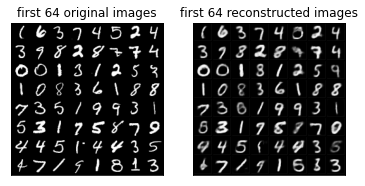

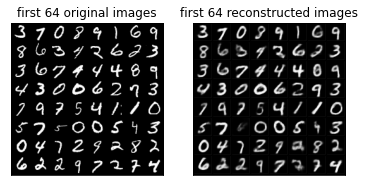

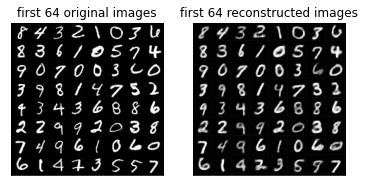

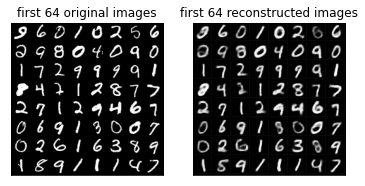

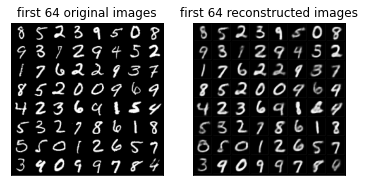

In [30]:
for (x, _), _ in zip(test_loader, range(5)): # limit test to first 5 batches.
    compressed = compress_batch_of_images(x)
    x_hat = decompress_batch_of_images(compressed)

    bitrate = len(compressed) * 32
    print(
        f'Compressed {len(x)} images into {bitrate} bits ' +
        f'({bitrate/len(x):.2f} bits per image, {bitrate/(len(x) * 28**2):.5f} bits per pixel)'
    )

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(make_grid(x[:64]).permute((1, 2, 0)))
    axs[0].set_title('first 64 original images')
    axs[1].imshow(make_grid(x_hat[:64]).permute((1, 2, 0)))
    axs[1].set_title('first 64 reconstructed images')
    for ax in axs:
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)